# Network Visualization

In [1]:
# Define custom names
custom_names_dict = {
"Anxiety": {
-1: "Daily Life Anxiety",
0: "Job Stress",
1: "Medication Effects",
2: "Panic Symptoms",
3: "Social Issues",
4: "Withdrawal Treatment Challenges",
5: "Family Issues"
},
"Depression": {
-1: "Past Emotional Losses",
0: "Relationship Energy Drains",
1: "Community Support Seeking",
2: "Inner Dialogue",
3: "Anxiety Sadness Burdens",
4: "Disability Financial Claim",
5: "Trauma Eating Disorders"
},
"PTSD and trauma": {
-1: "Childhood Abuse",
0: "Support Skepticism",
1: "Family Abuse",
2: "Therapy Healing Fears",
3: "Abusive Hurt Protection",
4: "Childhood Anger Trust",
5: "Financial Strain",
6: "Pain Flashback Anger",
7: "Masked Trauma",
8: "Sexual Abuse",
9: "Family Hurt"
},
"Suicidal thoughts and self-harm": {
-1: "Suicidal Pain Advice",
0: "Self-Harm Support",
1: "Suicidal Loss",
2: "Hesitant Pain Skepticism",
3: "Family Hurt Trust",
4: "Safety Plan Trusts",
5: "Inner Struggles",
6: "Parental Conflict",
7: "OCD Night Safety",
8: "Financial Stress",
9: "Workplace Strain",
10: "Lonely Family",
11: "Hopelessness"
}
}

C:\Users\user\AppData\Local\Temp\ipykernel_36620\1736453021.py:86: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab10", len(labels))


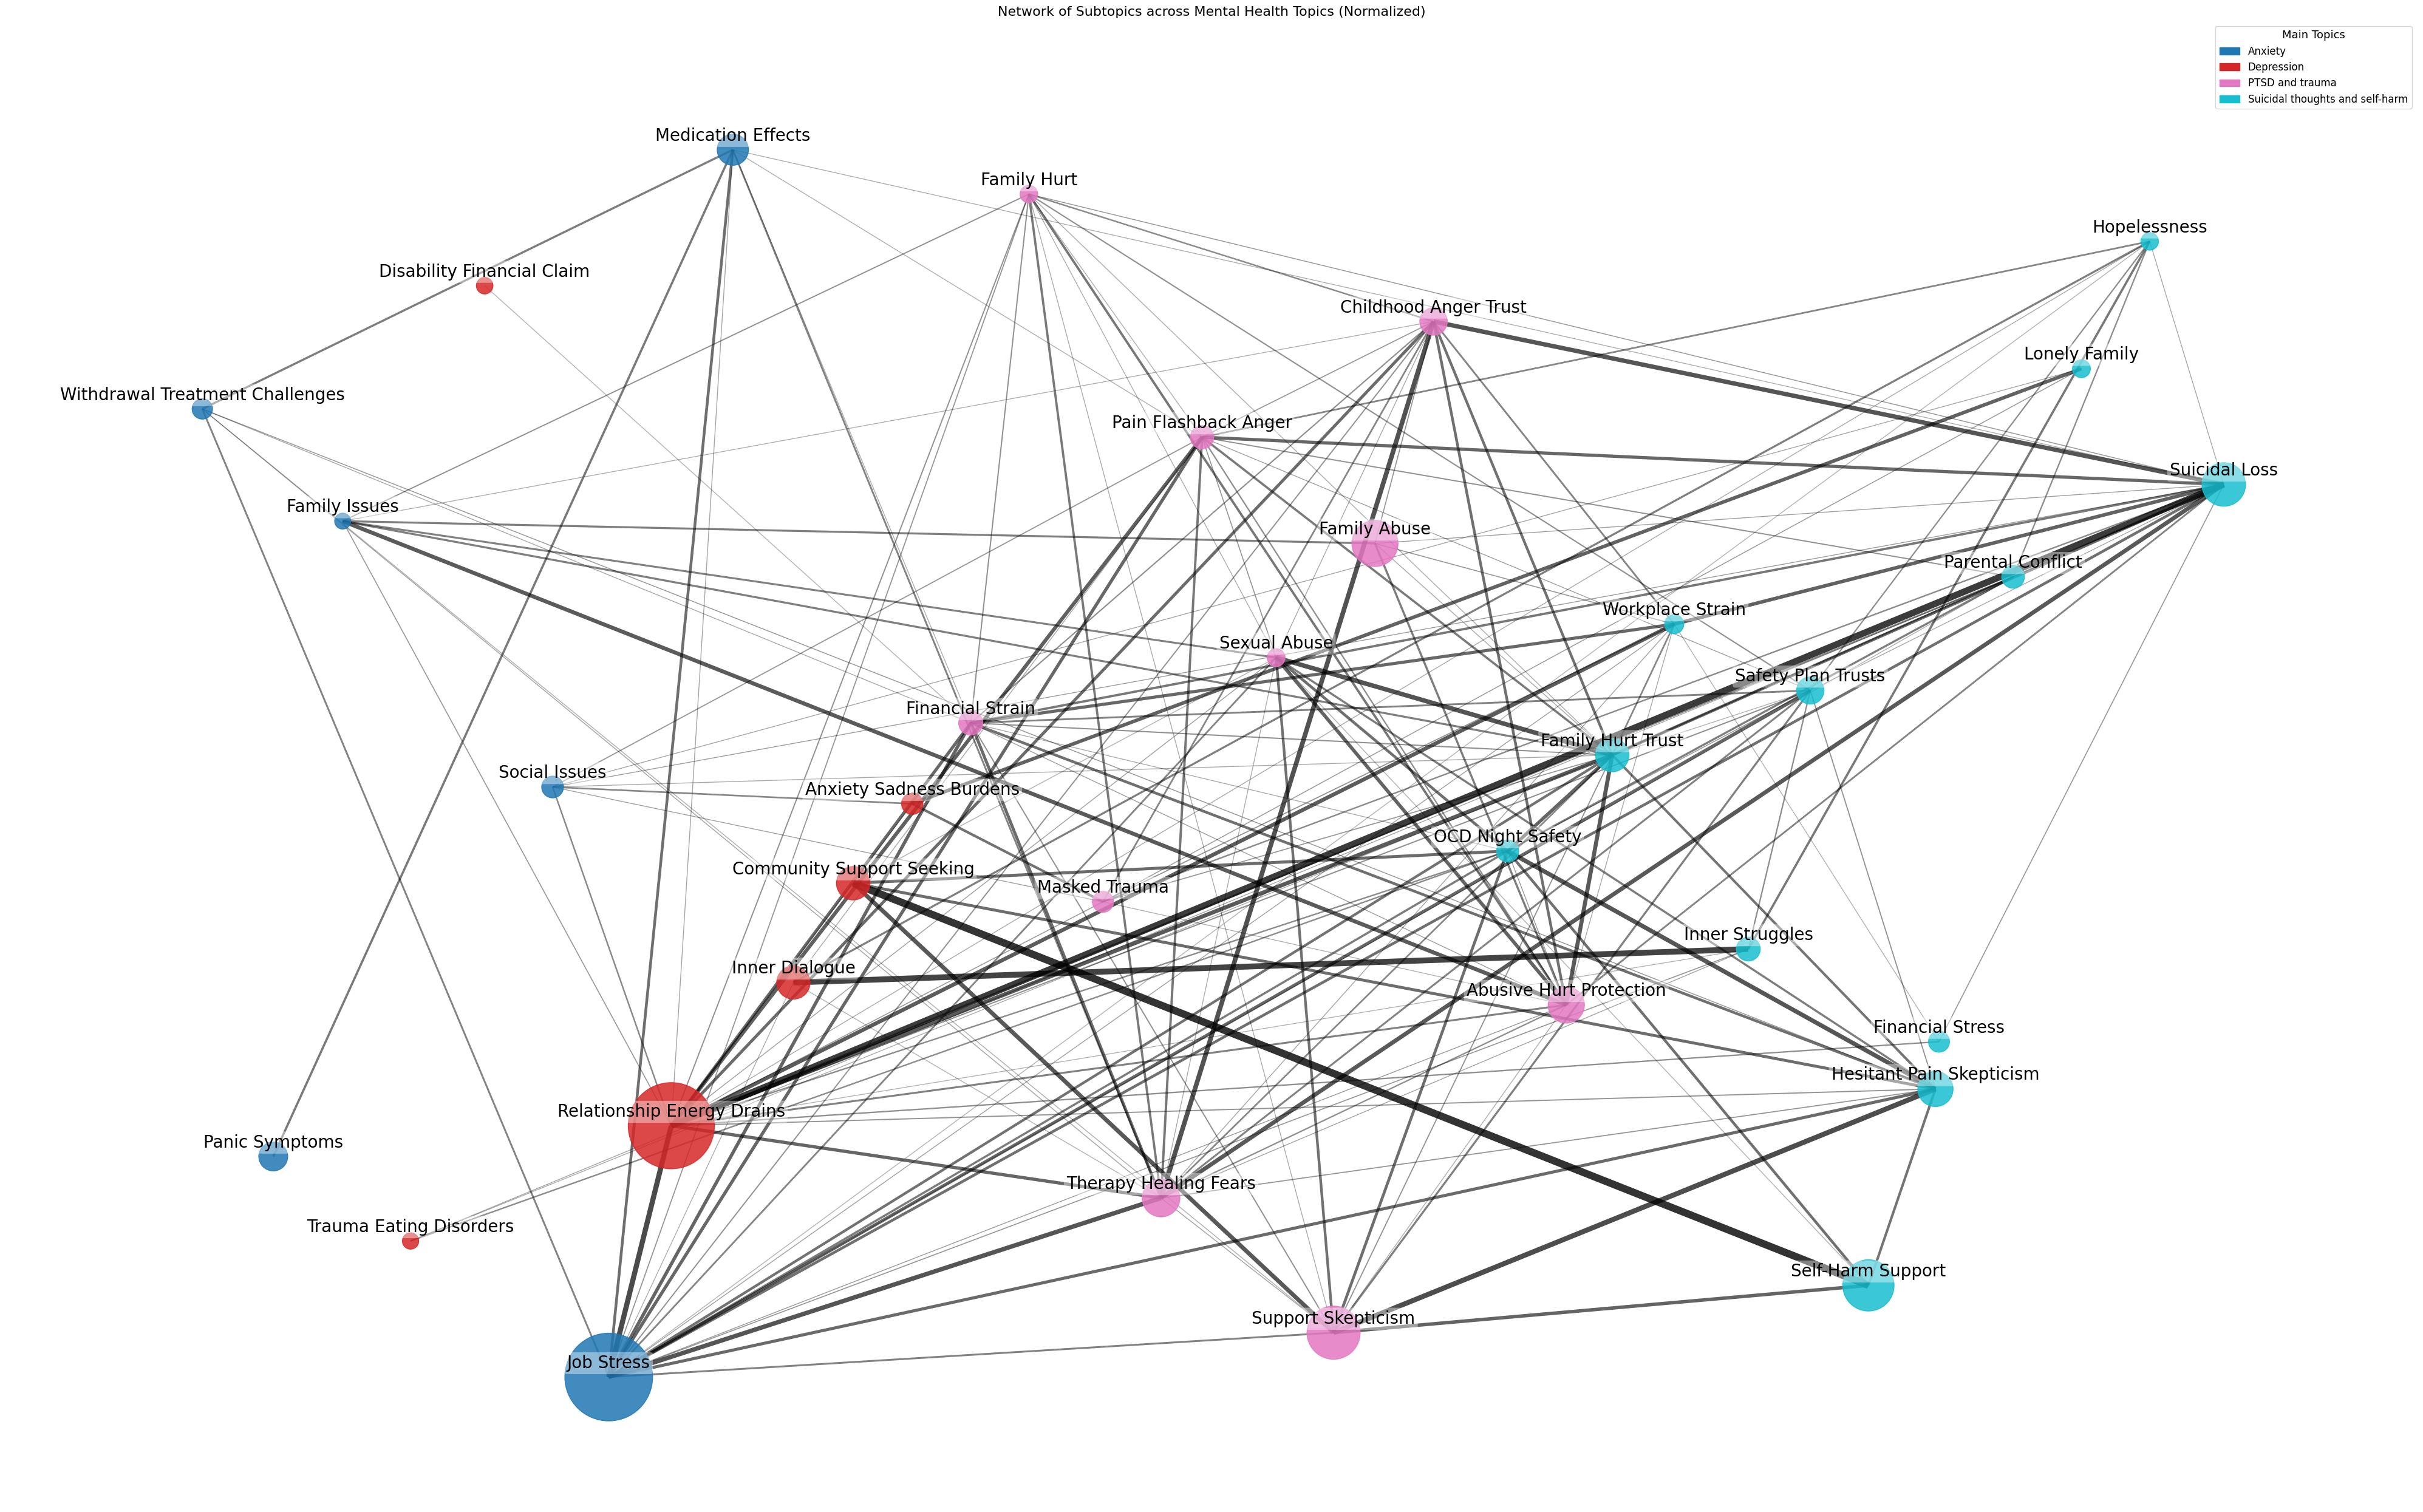

In [12]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from bertopic import BERTopic
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.patches as mpatches
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict



def load_model_and_subtopics(platform, label, custom_names):
    """Load BERTopic model and subtopic info with topic embeddings."""
    path = os.path.join(os.getcwd(), 'data', f'{platform}_data', 'berttopic_label', label)
    try:
        topic_model = BERTopic.load(os.path.join(path, f'{label}_berttopic'))
    except Exception as e:
        print(f"Error loading model for label '{label}': {e}")
        return []
    
    # Get topic assignments and info
    topic_info = topic_model.get_topic_info()
    topic_keywords = {t: topic_model.get_topic(t) for t in topic_info.Topic if t != -1}
    doc_counts = topic_info.set_index("Topic")["Count"].to_dict()
    # Total number of documents assigned to this label (excluding outliers)
    total_label_docs = sum([count for tid, count in doc_counts.items() if tid != -1])
    
    
    # Get topic embeddings (excluding -1 if present)
    topic_embeddings = topic_model.topic_embeddings_
    topic_ids = sorted([t for t in topic_keywords.keys()])  # Only valid topics
    if len(topic_embeddings) != len(topic_info):
        print(f"Warning: Mismatch between topic embeddings ({len(topic_embeddings)}) and topics ({len(topic_info)}) for label '{label}'.")
    
    subtopics = []
    for topic_id in topic_ids:
        keywords = [(kw, score) for kw, score in topic_keywords[topic_id]]
        doc_indices = [i for i, t in enumerate(topic_model.topics_) if t == topic_id]
        if not doc_indices:
            print(f"Warning: No documents assigned to topic {topic_id} in label '{label}'.")
            continue
        # Map topic_id to embedding index (assuming embeddings align with topic IDs)
        embedding_idx = topic_id + 1 if topic_id >= 0 else 0  # Adjust for -1 if present
        if embedding_idx >= len(topic_embeddings):
            print(f"Warning: No embedding for topic {topic_id} in label '{label}'.")
            continue
        subtopics.append({
            'model_label': label,
            'topic_id': topic_id,
            'name': custom_names.get(topic_id, f"{label}_{topic_id}"),
            'keywords': keywords,
            'doc_indices': doc_indices,
            'doc_count': doc_counts.get(topic_id, 0),
            'embedding': topic_embeddings[embedding_idx],
            'total_label_docs': total_label_docs
        })
    
    return subtopics

def network_vis(platform, labels, custom_names_dict, sim_threshold=0.9):
    all_subtopics = []
    
    for label in labels:
        custom_names = custom_names_dict.get(label, {})
        subtopics = load_model_and_subtopics(platform, label, custom_names)
        if not subtopics:
            print(f"Skipping label '{label}' due to loading issues.")
            continue
        all_subtopics.extend(subtopics)
    
    if not all_subtopics:
        print("Error: No subtopics available for visualization.")
        return nx.Graph()
    
    embeddings = np.array([t['embedding'] for t in all_subtopics])
    sim_matrix = cosine_similarity(embeddings)
    




    G = nx.Graph()
    cmap = get_cmap("tab10", len(labels))
    label_color = {label: cmap(i) for i, label in enumerate(labels)}
    
    # Add nodes with normalized sizes
    for idx, topic in enumerate(all_subtopics):
        relative_size = topic['doc_count'] / topic['total_label_docs']
        G.add_node(
            idx,
            label=topic['model_label'],
            name=topic['name'],
            keywords=', '.join([kw for kw, _ in topic['keywords'][:5]]),
            size=relative_size,
            true_doc_count=topic['doc_count'],
            color=label_color[topic['model_label']],
        )
    


    # Add edges based on similarity
    min_sim, max_sim = np.inf, -np.inf
    for i in range(len(all_subtopics)):
        for j in range(i + 1, len(all_subtopics)):
            sim = sim_matrix[i, j]
            if sim >= sim_threshold:
                G.add_edge(i, j, weight=sim)
                min_sim = min(min_sim, sim)
                max_sim = max(max_sim, sim)
    






    # Graph layout clustering by main topic
    pos = {}
    horizontal_scale = 1.5  # Increased horizontal separation
    vertical_scale = 2.5  # Increased vertical scale
    np.random.seed(42)  # For reproducible perturbations
    for i, label in enumerate(labels):
        nodes = [n for n, d in G.nodes(data=True) if d["label"] == label]
        subgraph = G.subgraph(nodes)
        # Dynamic offset based on number of nodes, increased factor
        offset_step = 12.0 * (len(nodes) / 10.0)
        sub_pos = nx.circular_layout(subgraph, scale=1.5)  # Increased scale
        
        for k in sub_pos:
            # Apply scaling for elliptical shape
            sub_pos[k][0] *= horizontal_scale
            sub_pos[k][1] *= vertical_scale
            sub_pos[k][0] += i * offset_step
        pos.update(sub_pos)






    def enforce_minimum_axis_distances(pos, min_dx=3.0, min_dy=3.0, max_iter=100):
        """Ensure nodes are at least `min_dx` apart in x and `min_dy` apart in y."""
        for _ in range(max_iter):
            moved = False
            nodes = list(pos.keys())
            for i in range(len(nodes)):
                for j in range(i + 1, len(nodes)):
                    node_i, node_j = nodes[i], nodes[j]
                    xi, yi = pos[node_i]
                    xj, yj = pos[node_j]
                    dx = abs(xi - xj)
                    dy = abs(yi - yj)
                    
                    if dx < min_dx:
                        # Push apart in x direction
                        shift_x = (min_dx - dx) / 2
                        if xi > xj:
                            pos[node_i] = (xi + shift_x, yi)
                            pos[node_j] = (xj - shift_x, yj)
                        else:
                            pos[node_i] = (xi - shift_x, yi)
                            pos[node_j] = (xj + shift_x, yj)
                        moved = True
                    
                    if dy < min_dy:
                        # Push apart in y direction
                        shift_y = (min_dy - dy) / 2
                        if yi > yj:
                            pos[node_i] = (xi, yi + shift_y)
                            pos[node_j] = (xj, yj - shift_y)
                        else:
                            pos[node_i] = (xi, yi - shift_y)
                            pos[node_j] = (xj, yj + shift_y)
                        moved = True
            
            if not moved:
                break
        return pos

    # Apply minimum axis distance enforcement
    pos = enforce_minimum_axis_distances(pos, min_dx=3.0, min_dy=3.5)








    # Draw the graph
    plt.figure(figsize=(40, 25))  # Increased figure size
    
    node_sizes = [G.nodes[n]['size'] * 15000 for n in G.nodes]  # normalized & scaled
    node_colors = [G.nodes[n]['color'] for n in G.nodes]
    
    if G.edges:
        # # Normalize similarity
        # edge_weights = [((G[u][v]['weight'] - min_sim) / (max_sim - min_sim + 1e-6)) * 5 + 0.5 for u, v in G.edges]


        # Improved edge weight scaling
        edge_weights = [G[u][v]['weight'] for u, v in G.edges]
        # Scale weights to range [1, 10] with emphasis on higher similarities
        scaler = MinMaxScaler(feature_range=(1, 15))
        scaled_weights = scaler.fit_transform(np.array(edge_weights).reshape(-1, 1)).flatten()
        # Apply exponential scaling to emphasize differences near the threshold
        scaled_weights = [2.5 * (np.exp(w / 10) - 1) for w in scaled_weights]
        # Ensure minimum visibility and cap maximum width
        scaled_weights = [min(max(w, 1.0), 12.0) for w in scaled_weights]
        # Adjust alpha for edges based on similarity
        edge_alphas = [0.3 + 0.5 * ((w - min(edge_weights)) / (max(edge_weights) - min(edge_weights) + 1e-6)) for w in edge_weights]
        


    else:
        edge_weights = []
        edge_alphas = []

    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85)
    for (u, v), width, alpha in zip(G.edges, scaled_weights, edge_alphas):
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=alpha)
    # nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.4)




    for node, (x, y) in pos.items():
        plt.text(
            x, y + 0.4,  # Increased upward shift
            G.nodes[node]['name'],
            fontsize=20,  # Increased font size
            ha='center',
            va='bottom',
            color='black',
            bbox=dict(boxstyle='round,pad=0.15', fc='white', ec='none', alpha=0.4)
        )
    
    
    

    legend_handles = [
        mpatches.Patch(color=label_color[label], label=label)
        for label in labels
    ]
    plt.legend(
        handles=legend_handles,
        loc="upper right",
        fontsize=12,
        title="Main Topics",
        title_fontsize=13
    )

    plt.title("Network of Subtopics across Mental Health Topics (Normalized)", fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    
    return G, sim_matrix, embeddings, pos, all_subtopics 



# Run the visualization
sim_threshold=0.9927 
platform = "beyondblue"
labels = ["Anxiety", "Depression","PTSD and trauma", "Suicidal thoughts and self-harm"]
G, sim_matrix, embeddings, pos, all_subtopics = network_vis(platform, labels, custom_names_dict, sim_threshold = sim_threshold)

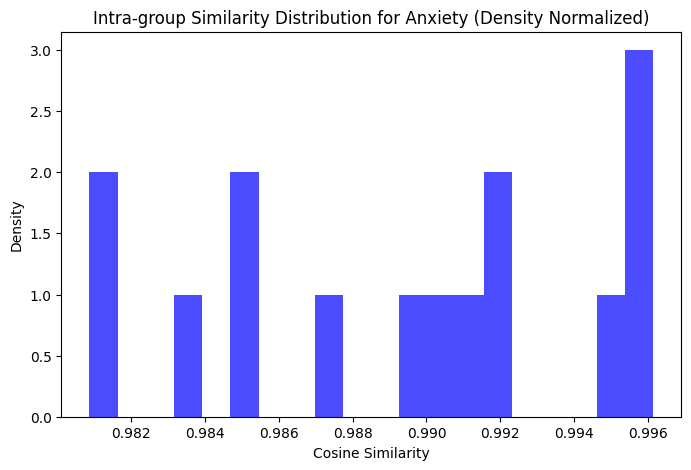

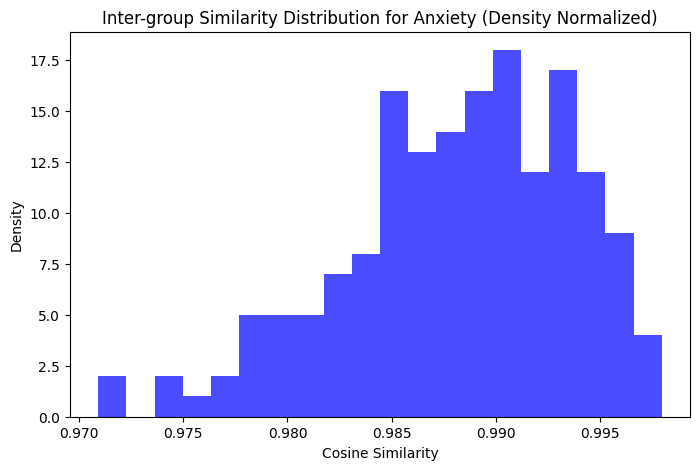

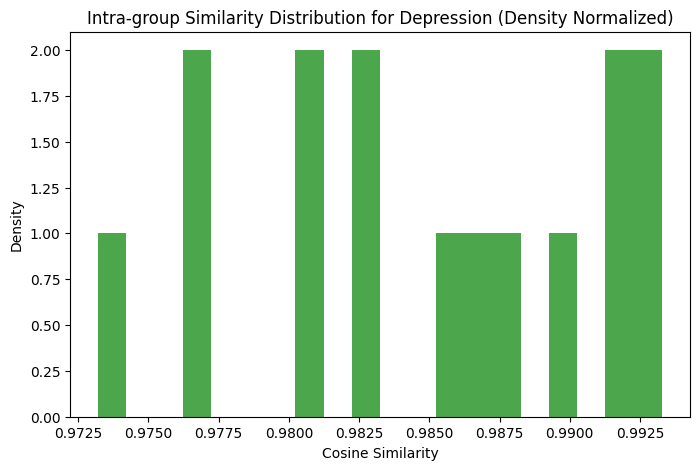

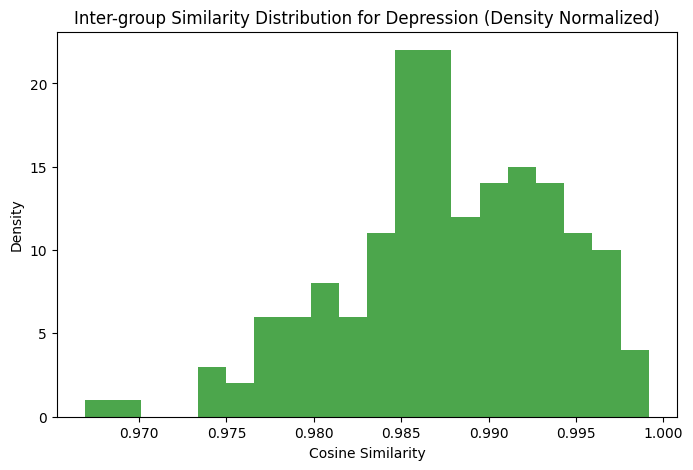

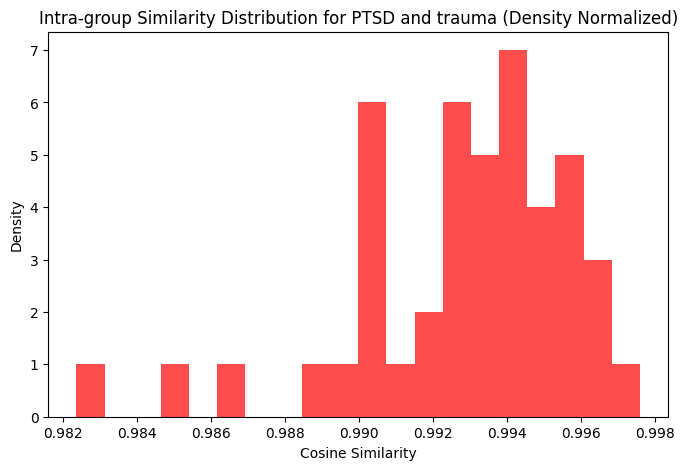

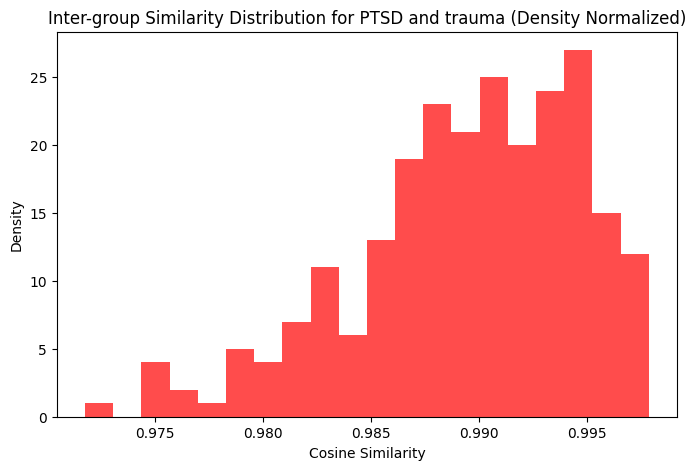

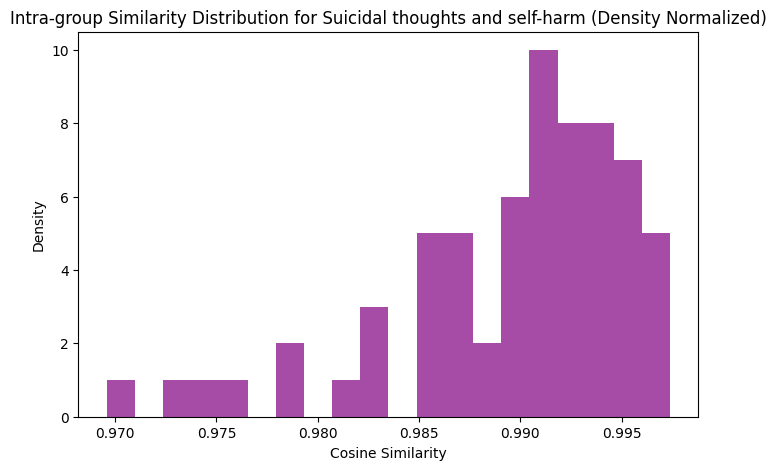

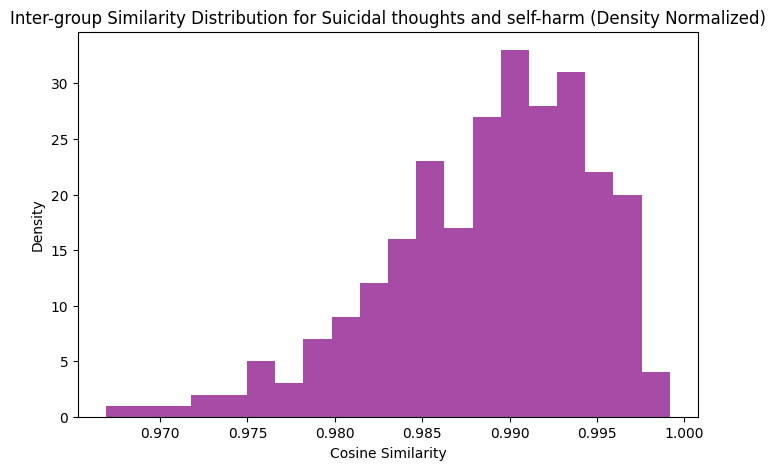

In [21]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Assuming all_subtopics and sim_matrix are available from previous code

# Map categories to their subtopic indices
category_to_indices = defaultdict(list)
for idx, topic in enumerate(all_subtopics):
    category_to_indices[topic['model_label']].append(idx)

# Collect intra-group similarities for each category
intra_sims = {}
for category, indices in category_to_indices.items():
    sims = []
    for i in range(len(indices)):
        for j in range(i + 1, len(indices)):
            sims.append(sim_matrix[indices[i], indices[j]])
    intra_sims[category] = sims

# Get all indices
all_indices = list(range(len(all_subtopics)))

# Collect inter-group similarities for each category
inter_sims = {}
for category, its_indices in category_to_indices.items():
    other_indices = [idx for idx in all_indices if idx not in its_indices]
    sims = []
    for i in its_indices:
        for j in other_indices:
            sims.append(sim_matrix[i, j])
    inter_sims[category] = sims

# Define colors for each category
colors = {'Anxiety': 'blue', 'Depression': 'green', 'PTSD and trauma': 'red', 'Suicidal thoughts and self-harm': 'purple'}

# Define the order of categories
categories = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]

# Create separate figures for each category, showing intra then inter
for category in categories:
    # Plot intra-group if available
    if category in intra_sims and intra_sims[category]:
        plt.figure(figsize=(8, 5))
        plt.hist(intra_sims[category], bins=20, alpha=0.7, color=colors.get(category, 'gray'), density=False)
        plt.title(f"Intra-group Similarity Distribution for {category} (Density Normalized)")
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Density")
        plt.show()
    
    # Plot inter-group if available
    if category in inter_sims and inter_sims[category]:
        plt.figure(figsize=(8, 5))
        plt.hist(inter_sims[category], bins=20, alpha=0.7, color=colors.get(category, 'gray'), density=False)
        plt.title(f"Inter-group Similarity Distribution for {category} (Density Normalized)")
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Density")
        plt.show()

1. Compare Intra- vs. Inter-Category Similarities (Bias Check)

In [31]:
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.utils import shuffle  # For permutations

# Extract node labels (main categories) from G
node_labels = [data['label'] for node, data in G.nodes(data=True)]
unique_labels = list(set(node_labels))
label_indices = {label: [i for i, lbl in enumerate(node_labels) if lbl == label] for label in unique_labels}

# Compute intra and inter similarities
intra_sims = []
inter_sims = []
for i in range(len(node_labels)):
    for j in range(i + 1, len(node_labels)):  # Upper triangle, exclude self
        sim = sim_matrix[i, j]
        if node_labels[i] == node_labels[j]:
            intra_sims.append(sim)
        else:
            inter_sims.append(sim)

print(f"Average Intra-Category Similarity: {np.mean(intra_sims):.4f}")
print(f"Average Inter-Category Similarity: {np.mean(inter_sims):.4f}")




# Statistical test (assume non-normal; use Mann-Whitney)
stat, p_value = mannwhitneyu(intra_sims, inter_sims, alternative='greater')
print(f"Mann-Whitney U Test: Statistic={stat:.2f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Significant: Intra similarities are higher than inter, suggesting category-specific structure.")



print("===============================================================================")




# Permutation test for robustness (null: shuffle labels 1000 times)
observed_diff = np.mean(intra_sims) - np.mean(inter_sims)
perm_diffs = []
for _ in range(2000):
    shuffled_labels = shuffle(node_labels)
    perm_intra, perm_inter = [], []
    for i in range(len(shuffled_labels)):
        for j in range(i + 1, len(shuffled_labels)):
            sim = sim_matrix[i, j]
            if shuffled_labels[i] == shuffled_labels[j]:
                perm_intra.append(sim)
            else:
                perm_inter.append(sim)
    perm_diffs.append(np.mean(perm_intra) - np.mean(perm_inter))
perm_p = np.sum(np.abs(perm_diffs) >= np.abs(observed_diff)) / len(perm_diffs)
# Since you expect intra > inter, test if observed difference is unusually large
# perm_p = np.sum(perm_diffs >= observed_diff) / len(perm_diffs)
print(f"Permutation Test p-value: {perm_p:.4f}")
if perm_p < 0.05:
    print("Reliable: Observed difference is significant vs. random label assignments.")

Average Intra-Category Similarity: 0.9901
Average Inter-Category Similarity: 0.9886
Mann-Whitney U Test: Statistic=34936.00, p-value=0.0007
Significant: Intra similarities are higher than inter, suggesting category-specific structure.
Permutation Test p-value: 0.0120
Reliable: Observed difference is significant vs. random label assignments.


2. Graph Modularity and Comparison to Null Models (Structure Reliability)

In [28]:
import networkx as nx
from networkx.algorithms.community import modularity

# Modularity using node labels as communities
communities = defaultdict(list)
for node, data in G.nodes(data=True):
    communities[data['label']].append(node)
obs_mod = modularity(G, list(communities.values()))
print(f"Observed Modularity: {obs_mod:.4f} (higher than 0.3-0.7 is good for real networks)")

# Null model: 100 random graphs with same degree sequence
null_mods = []
degrees = [d for n, d in G.degree()]
for _ in range(100):
    null_G = nx.configuration_model(degrees)
    null_G = nx.Graph(null_G)  # Remove multi-edges/self-loops
    null_mod = modularity(null_G, list(communities.values())) if null_G.edges else 0
    null_mods.append(null_mod)

null_mean = np.mean(null_mods)
null_p = np.sum(np.array(null_mods) >= obs_mod) / len(null_mods)
print(f"Null Model Mean Modularity: {null_mean:.4f}")
print(f"p-value (vs. Null): {null_p:.4f}")
if null_p < 0.05:
    print("Reliable: Modularity is significantly higher than random graphs, indicating non-random clustering.")

Observed Modularity: 0.0107 (higher than 0.3-0.7 is good for real networks)
Null Model Mean Modularity: 0.0025
p-value (vs. Null): 0.4100


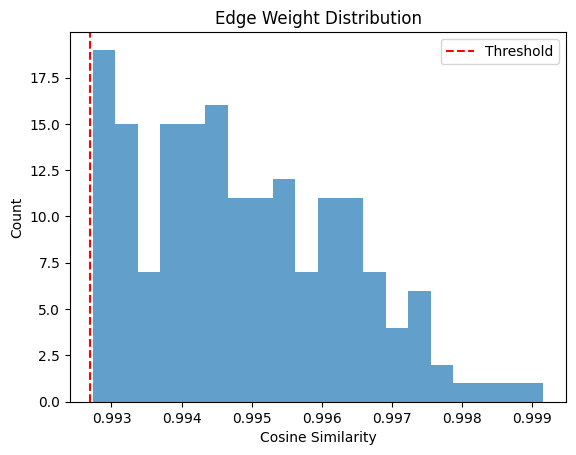

avg_clustering: 0.6687703387323969
modularity: 0.21038921109961464
degree_centrality: {'mean': 0.3083778966131907, 'max': 0.696969696969697}
betweenness_centrality: {'mean': 0.027907754010695188, 'max': 0.12878787878787878}
edge_weights: {'mean': 0.9948724573087483, 'std': 0.0014511236892972442, 'min': 0.9927300157127483, 'max': 0.9991627249242592}
z_score_range: (-1.4753850596823486, 2.954478084154908)
coverage: 1.0
label_purity: 0.3063583815028902


In [145]:
import networkx as nx
import numpy as np
from collections import Counter, defaultdict
from sklearn.metrics import normalized_mutual_info_score
import matplotlib.pyplot as plt

# Optional community detection
try:
    import community as community_louvain
except ImportError:
    community_louvain = None


def evaluate_network(G, sim_matrix, all_subtopics, sim_threshold=0.9):
    results = {}

    # --- 1. Clustering Coefficient ---
    results["avg_clustering"] = nx.average_clustering(G, weight="weight")

    # --- 2. Modularity (if community_louvain available) ---
    if community_louvain:
        partition = community_louvain.best_partition(G, weight="weight")
        modularity = community_louvain.modularity(partition, G, weight="weight")
        results["modularity"] = modularity
    else:
        results["modularity"] = None

    # --- 3. Centrality Measures ---
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G, weight="weight", normalized=True)

    results["degree_centrality"] = {
        "mean": np.mean(list(degree_centrality.values())),
        "max": max(degree_centrality.values(), default=0)
    }
    results["betweenness_centrality"] = {
        "mean": np.mean(list(betweenness_centrality.values())),
        "max": max(betweenness_centrality.values(), default=0)
    }

    # --- 4. Edge weight distribution and Z-scores ---
    edge_weights = [d["weight"] for _, _, d in G.edges(data=True)]
    if edge_weights:
        mean_w, std_w = np.mean(edge_weights), np.std(edge_weights)
        z_scores = [(w - mean_w) / (std_w + 1e-6) for w in edge_weights]

        results["edge_weights"] = {
            "mean": mean_w,
            "std": std_w,
            "min": min(edge_weights),
            "max": max(edge_weights)
        }
        results["z_score_range"] = (min(z_scores), max(z_scores))

        # Optional plot
        plt.hist(edge_weights, bins=20, alpha=0.7)
        plt.axvline(sim_threshold, color="red", linestyle="--", label="Threshold")
        plt.title("Edge Weight Distribution")
        plt.xlabel("Cosine Similarity")
        plt.ylabel("Count")
        plt.legend()
        plt.show()
    else:
        results["edge_weights"] = {}
        results["z_score_range"] = (None, None)

    # --- 5. Coverage (nodes with at least one edge / total nodes) ---
    covered_nodes = [n for n, d in G.degree() if d > 0]
    results["coverage"] = len(covered_nodes) / G.number_of_nodes()

    # --- 6. Label Purity (edges within same label vs across labels) ---
    intra_edges, inter_edges = 0, 0
    for u, v in G.edges():
        if G.nodes[u]["label"] == G.nodes[v]["label"]:
            intra_edges += 1
        else:
            inter_edges += 1
    total_edges = intra_edges + inter_edges
    if total_edges > 0:
        results["label_purity"] = intra_edges / total_edges
    else:
        results["label_purity"] = None

    return results


results = evaluate_network(G, sim_matrix, embeddings, sim_threshold=sim_threshold)
for k, v in results.items():
    print(f"{k}: {v}")


Regression model 

line plot for whole main topics 

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns


current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]


main_symptoms_df = []
for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}','label_df.csv'))
    main_symptoms_df.append(df)

main_symptoms_df = pd.concat(main_symptoms_df, ignore_index=True)
main_symptoms_df['year'] = pd.to_datetime(main_symptoms_df['Post Date']).dt.year
main_symptoms_df['Post Category'] = main_symptoms_df['Post Category'].str.strip()

print(main_symptoms_df.shape)
# check how many missing value in the year column
print("Missing values in 'year' column:", main_symptoms_df['year'].isna().sum())






# Group and count number of posts per year per category
post_counts = main_symptoms_df.groupby(['year', 'Post Category']).size().reset_index(name='Post Count')

# Now plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=post_counts, x='year', y='Post Count', hue='Post Category', marker='o')
plt.title('Number of Posts by Year and Post Category')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.legend(title='Post Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

line plot for  subtopics for each main topics

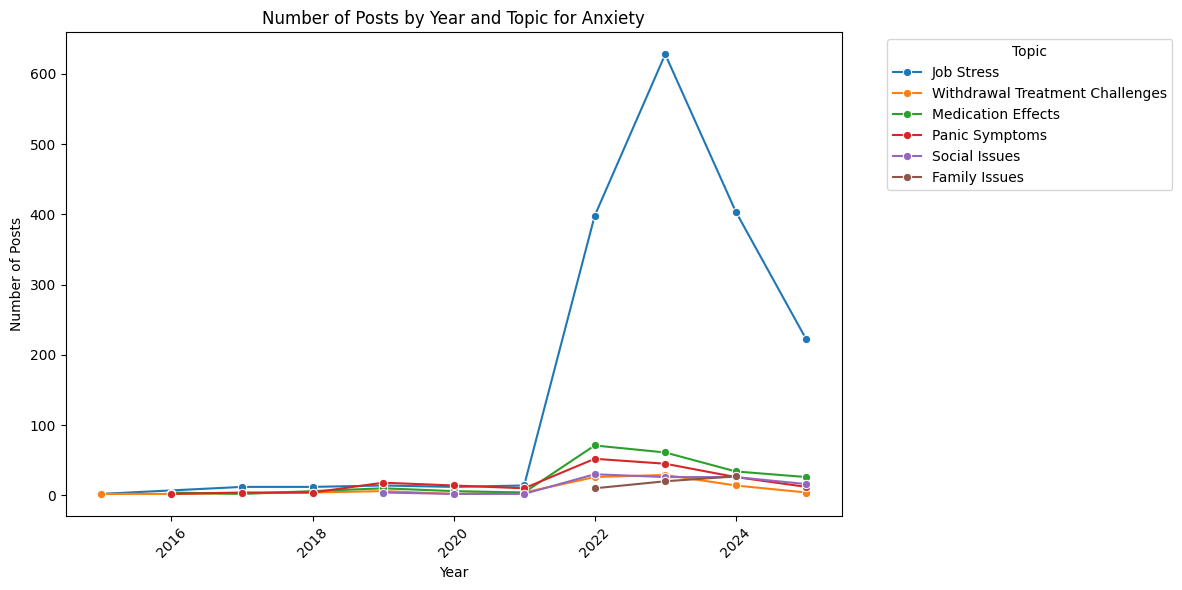

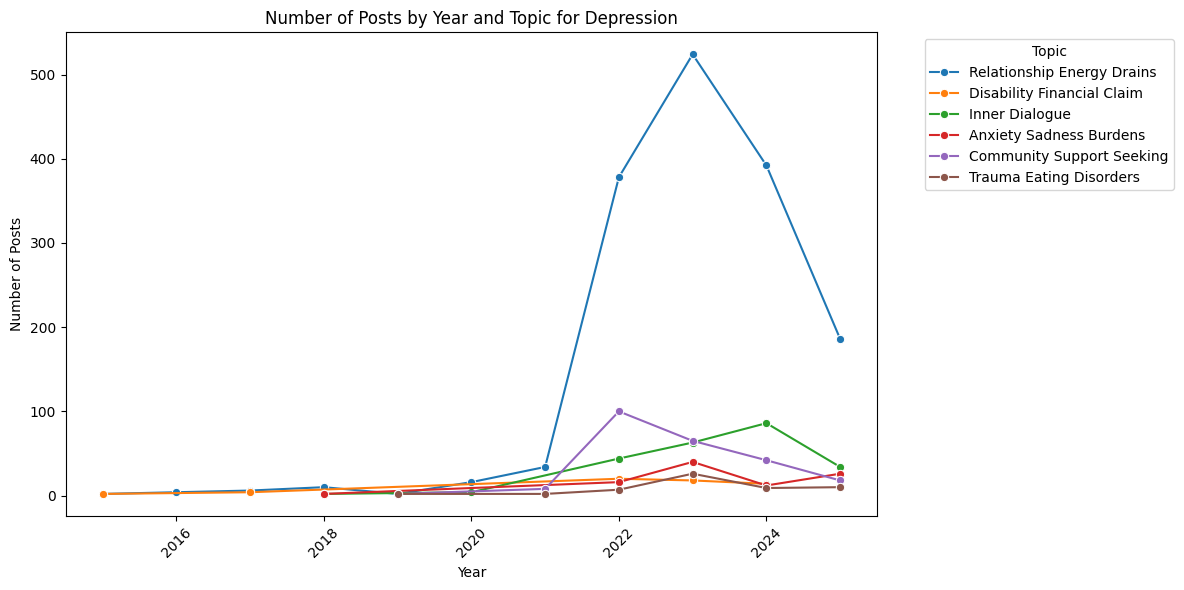

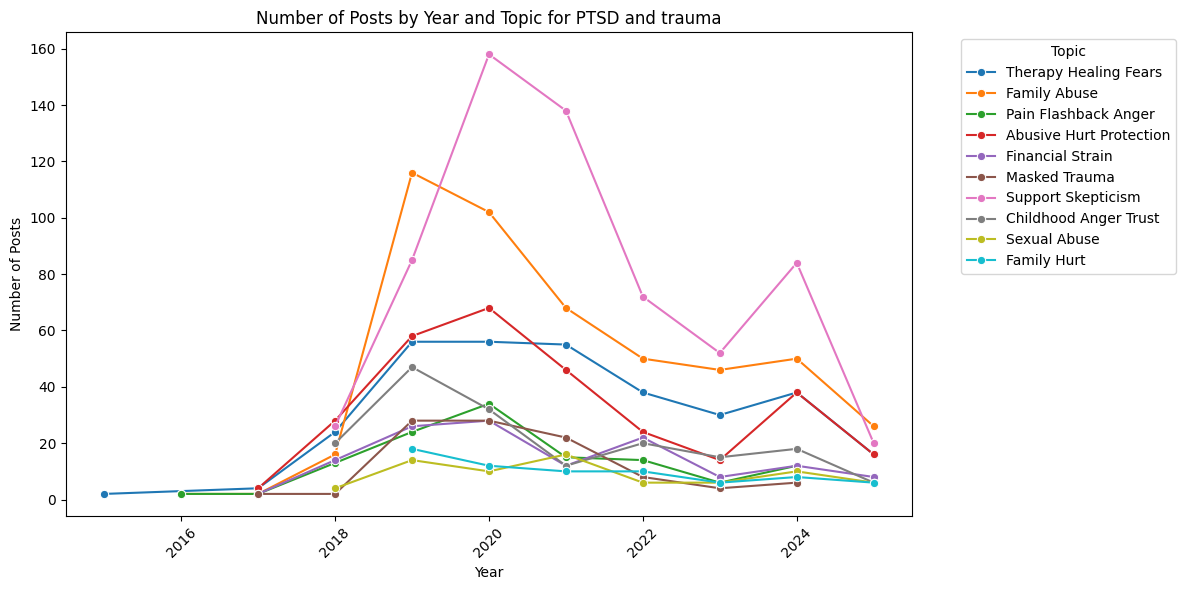

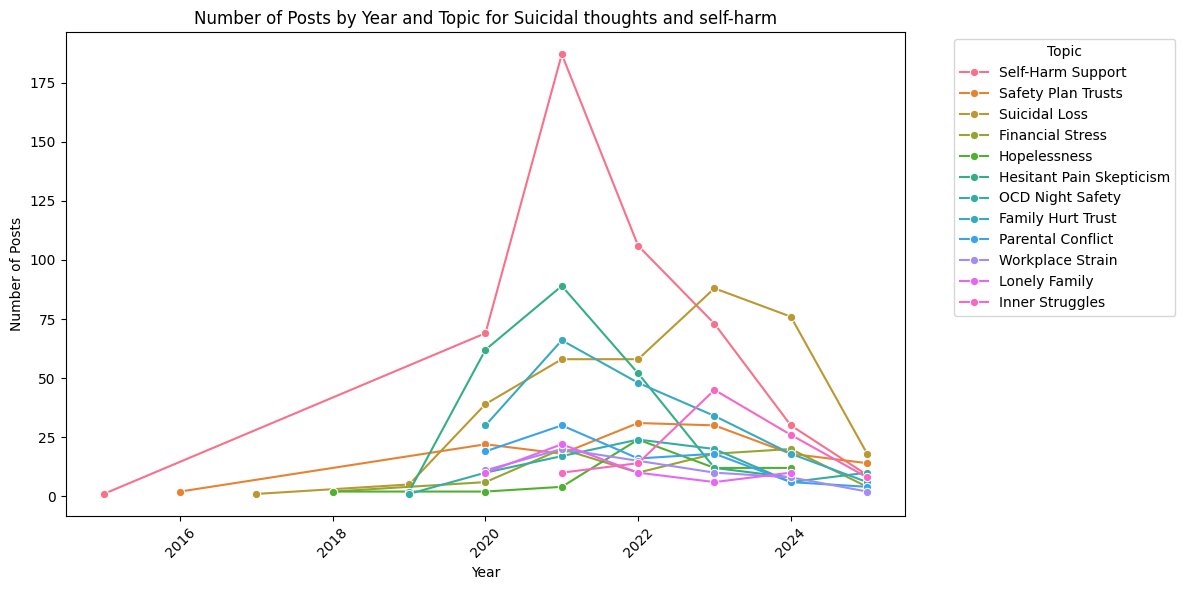

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns



current_dir = os.getcwd()
platform = "beyondblue"
labels = ["Anxiety", "Depression", "PTSD and trauma", "Suicidal thoughts and self-harm"]



for label in labels:
    df = pd.read_csv(os.path.join(current_dir, 'data',f'{platform}_data','berttopic_label',f'{label}',f'{label}_topic_docs.csv'))

    # draw the line plot according to the number of posts for each topic(custome topic) by year excludinf -1 topic
    df['year'] = pd.to_datetime(df['Post Date']).dt.year
    df = df[df['Topic'] != -1]  # Exclude outliers
    topic_counts = df.groupby(['year', 'Topic']).size().reset_index(name='Post Count')
    topic_counts['Topic'] = topic_counts['Topic'].replace(custom_names_dict[label])
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=topic_counts, x='year', y='Post Count', hue='Topic', marker='o')
    plt.title(f'Number of Posts by Year and Topic for {label}')
    plt.xlabel('Year')
    plt.ylabel('Number of Posts')
    plt.xticks(rotation=45)
    plt.legend(title='Topic', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    # plt.savefig(os.path.join(current_dir, 'data', f'{platform}_data', 'berttopic_label', f'{label}', f'{label}_topic_yearly_counts.png'))
    plt.show()
    
    

    